In [1]:
import math
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize
from numpy.random import default_rng
from IPython.display import Image
from scipy.stats import expon

# Using Discrete Event Simulation to help plan purchasing in an organisation 

Inorder to purchase items, it is common for organisations to require a set process for its members. Some organisations have dedicated departments and/or employees for this, such as the purchasing department, clerk etc. The title of the responsible entity may differ across organisations, however, the responsibilities tend to be similar. For organisations with a projectized structure, the project coordinators take up this responsibility, and depending on the size of the projectized organisation, other entities such as the finance department and the indirectbuyer can be involved. Here is an example of the flow of purchasing in such an organisation.

Send application/request --> Create Purchase Requisition (PR) --> Approve Purchase Requisition --> place order (if online) --> issue PO to merchants --> Exit

Members/Employees of the organisation send applications/requests (by email) to project coordinators. Project Coordinators create **Purchase Requisitions** and route them to finance for approval. Once approved, purchase requisitions for items that are to be purchased online are routed to project coordinators to place order. Approved purchase requisitions are routed to the indirect buyers of the organisation to issue **Purchase Orders**

For this model, the above flow will be adpoted. Here are the model components:

* The entities are applications
* Entities are created when applications/requests are sent to project coordinators
* Each stage of the process has a set number of resources such as project coordinators, members of the finance department responsible for reviewing and approving PRs, project coordinators to place online orders, and Indirect buyers to issue POs
* Entities flow through different stages of the purchase requisition process, and at each stage, they:
    - request one unit of the appropriate type of staff resource and wait if one is not available,
    - after obtaining a staff resource they delay for some amount of time for the process to be completed,
    - when the processing time has elapsed, the resource is released and the PR moves on to the next stage of the purchase requisition process (Mark Isken, 2021)
* After the PO has been issued, the process ends for that PR.

Our model should handle:
* Uncertainty in the processing times of the individual steps above
* Uncertainty in the application arrival times
* Finite number of different types of resources
* ability to estimate key process metrics such as application wait times, total time for completion, resource utilisation (Mark Isken, 2021)

Model characteristics
* The python library used for this model is __[SimPy](https://simpy.readthedocs.io/en/latest/)__
* The arrival of applications is exponentially distributed *Poisson arrival process* (exponential distribution)
* The time for the other stages (approve PR, place order, issue PO) are modeled as a normal distribution with the given mean and standard deviation

This model could assist in deciding the number of resources needed at each stage of the process.


## Stages in building the Purchase Requisition model

This covers the different steps taken to build the model

### Generate PR applications

A model that generates a new application every n minutes

In [2]:
# function to generate applications
def PR_application(env, interapplication_time=5.0):
    """Generate Applications according to a fixed time arrival process"""
    
    # Counter to keep track of number of Applications generated and to serve as a unique Application ID
    application = 0
    
    # Infinite loop for generating Applications
    while True:
        
        # Generate next interapplication time (in minutes)
        iat = interapplication_time
        
        # yield 'timeout' event
        yield env.timeout(iat)
        
        # generate new application
        application += 1
        
        print(f"Application {application} created at time {env.now}")
        

In [3]:
# Initialize a simulation environment
env1 = simpy.Environment()

# Create and start process generator, and add it to the env (for 1 workday - [60x8] mins )
runtime = 60 * 8
interapplication_time = 35.0
env1.process(PR_application(env1, interapplication_time))

# Run the simulation
env1.run(until=runtime)

Application 1 created at time 35.0
Application 2 created at time 70.0
Application 3 created at time 105.0
Application 4 created at time 140.0
Application 5 created at time 175.0
Application 6 created at time 210.0
Application 7 created at time 245.0
Application 8 created at time 280.0
Application 9 created at time 315.0
Application 10 created at time 350.0
Application 11 created at time 385.0
Application 12 created at time 420.0
Application 13 created at time 455.0


### Modeling the arrival of applications (*Poisson Arrival Process*)

The Purchase requisiton applications/requests will be modeled as an exponential distribution with the mean of the distribution as the `interapplication_time`

In [4]:
# function to model the arrival of applications
def Purchase_application_random_1(env, mean_interapplication_time=5.0, rg=default_rng(0)):
    """Generate applications according to a Poisson arrival process"""
    
    # Counter to keep track of number of applications generated and to serve as a unique application ID
    application = 0
    
    # Infinite loop for generating applications
    while True:
        
        # Generate next interapplication time (exponential distribution with a mean of the mean_interapplication_time)
        iat = rg.exponential(mean_interapplication_time)
        
        # yield 'timeout' event
        yield env.timeout(iat)
        
        # generate new application
        application += 1
        
        print(f"application {application} created at time {env.now}")
        

In [5]:
# Initialize a simulation environment
env2 = simpy.Environment()

# Create and start process generator, and add it to the env (for 1 workday - [60x8] mins )
runtime = 60 * 8
interapplication_time = 35.0
env2.process(Purchase_application_random_1(env2, interapplication_time))

# Run the simulation
env2.run(until=runtime)

application 1 created at time 23.797616638911833
application 2 created at time 59.4835151902171
application 3 created at time 60.176748380834034
application 4 created at time 60.256174814677024
application 5 created at time 79.51817535704372
application 6 created at time 136.5660905700872
application 7 created at time 160.1414939134403
application 8 created at time 186.577041437329
application 9 created at time 285.16455070497943


### Include project coordinator resource to model 

The coordinator resource is added to the model to create PR for time = `mean_creation_time`, and a `mean_postcreation_time` is added to simulate events after the PR has been created

In [6]:
def Purchase_application_Simplified(env, employee, mean_precreation_time, mean_creation_time, mean_postcreation_time, coordinator, rg=default_rng(0)):
    """Process function modeling how a PR flows through system."""
    print(f"{employee} applied for PR at {env.now:.4f}")
    
    # Yield for the precreation time
    yield env.timeout(rg.exponential(mean_precreation_time))
    
    # Request project coordinator to create PR
    with coordinator.request() as request:
        print(f"{employee} requested coordinator at {env.now:.4f}")
        yield request
        print(f"PR created for {employee} at {env.now:.4f}")
        yield env.timeout(rg.normal(mean_creation_time, 0.5))
        
    # Yield for the postcreation time
    yield env.timeout(mean_postcreation_time)
    
    # Process over
    print(f"{employee} received P.O. at {env.now:.4f}")

**Combining project coordinator resource model with poisson arrival model**

In [7]:
def Purchase_application_random_2(env, mean_interapplication_time, mean_precreation_time, mean_creation_time,
                              mean_postcreation_time, coordinator,  rg=default_rng(0)):
    """Generate applications according to a Poisson arrival process"""
    
    # Counter to keep track of number of applications generated and to serve as a unique application ID
    application = 0
    
    # Infinite loop for generating applications
    while True:
        
        # Generate next interarrival time
        iat = rg.exponential(mean_interapplication_time)
        
        # yield 'timeout' event
        yield env.timeout(iat)
        
        # generate new application
        application += 1
        
        print(f"application {application} created at time {env.now}")
        
        # Register the process with the simulation environment
        env.process(Purchase_application_Simplified(env, 'Employee{}'.format(application), mean_precreation_time,
                                                    mean_creation_time, mean_postcreation_time, coordinator))
        
        
        

In [8]:
# Initialize a simulation environment
env3 = simpy.Environment()

# Set input values
# rg = default_rng(seed=4470)
mean_interapplication_time = 3.0
mean_precreation_time = 5.0
mean_creation_time = 30
mean_postcreation_time = 120
num_coordinators = 4

# Create Coordinator resource
coordinator = simpy.Resource(env3, num_coordinators)

# register new application process
env3.process(Purchase_application_random_2(env3, mean_interapplication_time, mean_precreation_time, mean_creation_time,
                                           mean_postcreation_time, coordinator))

# Run the simulation
runtime = 50
env3.run(until=runtime)

application 1 created at time 2.039795711906729
Employee1 applied for PR at 2.0398
application 2 created at time 5.098587016304323
Employee2 applied for PR at 5.0986
application 3 created at time 5.158007004071489
Employee3 applied for PR at 5.1580
application 4 created at time 5.164814984115174
Employee4 applied for PR at 5.1648
Employee4 requested coordinator at 5.1762
PR created for Employee4 at 5.1762
Employee3 requested coordinator at 5.2570
PR created for Employee3 at 5.2570
Employee1 requested coordinator at 5.4395
PR created for Employee1 at 5.4395
application 5 created at time 6.815843602032318
Employee5 applied for PR at 6.8158
Employee2 requested coordinator at 10.1966
PR created for Employee2 at 10.1966
Employee5 requested coordinator at 10.5924
application 6 created at time 11.705664906007474
Employee6 applied for PR at 11.7057
application 7 created at time 13.72641376400917
Employee7 applied for PR at 13.7264
application 8 created at time 15.992317837485343
Employee8 appl

## The Purchase Requisition model

The *purchase requisition* process will be modeled with a python class with these attributes:

* the SimPy environment
* resource capacity related inputs
* data structures to store data collected as applications flow through the system
* the SimPy resources for modeling the various types of staff modeled
* process methods corresponding to processing times in each stage in the PR flow diagram

In [55]:
class purchase_requisition(object):
    def __init__(self, env, num_coordinators, num_approvers, num_indirectbuyers, rg):
        # Simulation environment
        self.env = env
        self.rg = rg
        
        # list to hold timestamps dictionaries (one per PR)
        self.timestamps_list = []
        # list to hold PR queues (time, queue)
        self.pr_queue = [(0.0, 0.0)]
        self.postapproval_queue = [(0.0, 0.0)]
        
        # Create resources
        self.coordinator = simpy.Resource(env, num_coordinators)
        self.approver = simpy.Resource(env, num_approvers)
        self.indirectbuyer = simpy.Resource(env, num_indirectbuyers)
        
    # Process methods
    def create_PR(self, application):
        yield self.env.timeout(self.rg.exponential(15.0))
        
    def approve(self, application):
        yield self.env.timeout(self.rg.normal(5.0, 1.0))
        
    def create_order(self, application):
        yield self.env.timeout(self.rg.normal(10.0, 3.0))
        
    def create_po(self, application):
        yield self.env.timeout(self.rg.normal(5.0, 1.0))
        

### The purchase function

The `purchase` function is created to define the stages an application/purchase requisition goes through in the organisation. The function will capture timestamps for performance measures such as waiting times and resource utilization. The function inputs include:

* the simulation environment
* the Purchase Requisition I.D
* the Purchase Requisition object (created from the purchase_requisition class)
* the percentage of online orders
* the random number generator

In [56]:
def purchase(env, application, purchase_requisition, pct_online, rg):
    # An application is received
    app_request_ts = env.now
    
    # release coordinator to create PR
    with purchase_requisition.coordinator.request() as request:
        yield request
        # With coordinator, create application
        got_coordinator_ts = env.now
        
        # increase and updated PR queue
        purchase_requisition.pr_queue.append((env.now, purchase_requisition.pr_queue[-1][1] + 1))
        
        yield env.process(purchase_requisition.create_PR(application))
        release_coordinator_ts = env.now
        
    # Request approver to approve PR
    with purchase_requisition.approver.request() as request:
        yield request
        got_approver_ts = env.now
        yield env.process(purchase_requisition.approve(application))
        release_approver_ts = env.now
        
        # decrease and update PR queue
        purchase_requisition.pr_queue.append((env.now, purchase_requisition.pr_queue[-1][1] - 1))
        
        # increase and update post approval queue
        purchase_requisition.postapproval_queue.append((env.now, purchase_requisition.postapproval_queue[-1][1] + 1))
        
    # if online order, request coordinator to place order on online
    if rg.random() < pct_online:
        with purchase_requisition.coordinator.request() as request:
            yield request
            got_coordinator2_ts = env.now
            yield env.process(purchase_requisition.create_order(application))
            release_coordinator2_ts = env.now      
    else:
        got_coordinator2_ts = pd.NA
        release_coordinator2_ts = pd.NA
    
    # Request indirect buyer to issue PO
    with purchase_requisition.indirectbuyer.request() as request:
        yield request
        got_indirectbuyer_ts = env.now
        yield env.process(purchase_requisition.create_po(application))
        release_indirectbuyer_ts = env.now
        
        # decrease and update post approval queue
        purchase_requisition.postapproval_queue.append((env.now, purchase_requisition.postapproval_queue[-1][1] -1))
        
        
    exit_system_ts = env.now
    # print(f'PO has been issued for purchase requisition application {application}')
    
    # Create dictionary of timestamps
    timestamps = {'application_id': application,
                  'app_request_ts': app_request_ts,
                  'got_coordinator_ts': got_coordinator_ts,
                  'release_coordinator_ts': release_coordinator_ts,
                  'got_approver_ts': got_approver_ts,
                  'release_approver_ts': release_approver_ts,
                  'got_coordinator2_ts': got_coordinator2_ts,
                  'release_coordinator2_ts': release_coordinator2_ts,
                  'got_indirectbuyer_ts': got_indirectbuyer_ts,
                  'release_indirectbuyer_ts': release_indirectbuyer_ts,
                  'exit_system_ts': exit_system_ts}
    
    purchase_requisition.timestamps_list.append(timestamps)
                  

### The run_pr function

The `run_pr function` will run the **Purchase Requisition** process. The function includes:

* the simulation environment
* the purchase requisition object
* the mean interapplication time
* the percentage of requisitions containing online items
* the random number generator
* stopping condition for the simulation through either a stop time or a maximum number of applications

In [57]:
def run_pr(env, purchase_requisition, mean_interapplication_time, pct_online, rg,
           stoptime=simpy.core.Infinity, max_applications=simpy.core.Infinity):
    
    # application counter/ID
    application = 0
    
    # Loop for generating applications
    while env.now < stoptime and application < max_applications:
        
        iat = rg.exponential(mean_interapplication_time)
        yield env.timeout(iat)
        application += 1
        
        # print(f"Purchase Requisition application {application} created at time {env.now}")
        
        env.process(purchase(env, application, purchase_requisition, pct_online, rg))
        

**Function to launch simulation**

In [58]:
def main():
    # input parameters
    applications_per_hour = 20
    mean_interapplication_time = 1.0 / (applications_per_hour / 60.0)
    pct_online = 0.25
    
    # Random number generator seed
    rg = default_rng(seed=4470)
    
    # Resource capacity levels
    num_coordinators = 7
    num_approvers = 2
    num_indirectbuyers = 2
    
    # minutes of operation
    stoptime = 8*60
    
    # Create simulation environment
    env = simpy.Environment()
    
    # create purchase requisition to simulate
    requisition = purchase_requisition(env, num_coordinators, num_approvers, num_indirectbuyers, rg)
    
    # Register PR creation function
    env.process(run_pr(env, requisition, mean_interapplication_time, pct_online, rg, stoptime=stoptime))
    # Run simulation
    env.run()
    
    # Output log files
    pr_application_log_df = pd.DataFrame(requisition.timestamps_list)
    pr_application_log_df.to_csv('./output/pr_application_log_df.csv', index=False)
    
    pr_queue_df = pd.DataFrame(requisition.pr_queue, columns=['ts', 'queue'])
    pr_queue_df.to_csv('./output/pr_queue_df.csv', index=False)
    
    postapproval_queue_df = pd.DataFrame(requisition.postapproval_queue, columns=['ts', 'queue'])
    postapproval_queue_df.to_csv('./output/postapproval_queue_df.csv', index=False)
    
    # Simulation end time
    end_time = env.now
    print(f"Simulation ended at time {end_time}")
    return (end_time)
    

In [59]:
pr_end_time = main()

Simulation ended at time 530.3733621744279


## Post-processing


In [51]:
# Read application log file
pr_application_log_df = pd.read_csv('./output/pr_application_log_df.csv')
pr_application_log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   application_id            162 non-null    int64  
 1   app_request_ts            162 non-null    float64
 2   got_coordinator_ts        162 non-null    float64
 3   release_coordinator_ts    162 non-null    float64
 4   got_approver_ts           162 non-null    float64
 5   release_approver_ts       162 non-null    float64
 6   got_coordinator2_ts       32 non-null     float64
 7   release_coordinator2_ts   32 non-null     float64
 8   got_indirectbuyer_ts      162 non-null    float64
 9   release_indirectbuyer_ts  162 non-null    float64
 10  exit_system_ts            162 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 14.0 KB


In [52]:
pr_application_log_df.head()

,application_id,app_request_ts,got_coordinator_ts,release_coordinator_ts,got_approver_ts,release_approver_ts,got_coordinator2_ts,release_coordinator2_ts,got_indirectbuyer_ts,release_indirectbuyer_ts,exit_system_ts
0,6,9.078269,9.078269,10.465810,10.465810,14.934542,NaN,NaN,14.934542,22.201006,22.201006
1,7,14.707528,14.707528,17.002133,17.002133,20.150655,NaN,NaN,20.150655,23.958605,23.958605
2,2,2.595354,2.595354,17.255910,17.255910,23.150843,NaN,NaN,23.150843,29.731249,29.731249
3,1,2.332475,2.332475,19.757187,20.150655,25.421086,NaN,NaN,25.421086,30.554284,30.554284
4,5,8.573990,8.573990,9.178599,9.178599,13.945390,13.94539,28.169596,29.731249,34.328858,34.328858


In [53]:
def compute_durations(timestamp_df):
    
    timestamp_df['wait_for_coordinator'] = timestamp_df.loc[:, 'got_coordinator_ts'] - timestamp_df.loc[:, 'app_request_ts']
    timestamp_df['time_to_create_PR'] = timestamp_df.loc[:, 'release_coordinator_ts'] - timestamp_df.loc[:, 'got_coordinator_ts']
    timestamp_df['wait_for_approver'] = timestamp_df.loc[:, 'got_approver_ts'] - timestamp_df.loc[:, 'release_coordinator_ts']
    timestamp_df['time_to_approve'] = timestamp_df.loc[:, 'release_approver_ts'] - timestamp_df.loc[:, 'got_approver_ts']
    timestamp_df['wait_for_indirectbuyer'] = timestamp_df.loc[:, 'got_indirectbuyer_ts'] - timestamp_df.loc[:, 'release_approver_ts']
    timestamp_df['time_to_issue_po'] = timestamp_df.loc[:, 'release_indirectbuyer_ts'] - timestamp_df.loc[:, 'got_indirectbuyer_ts']
    timestamp_df['post_approval_time'] = timestamp_df.loc[:, 'exit_system_ts'] - timestamp_df.loc[:, 'release_approver_ts']
    timestamp_df['time_in_system'] = timestamp_df.loc[:, 'exit_system_ts'] - timestamp_df.loc[:, 'app_request_ts']
    
    return timestamp_df

In [54]:
pr_application_log_df = compute_durations(pr_application_log_df)
pr_application_log_df

,application_id,app_request_ts,got_coordinator_ts,release_coordinator_ts,got_approver_ts,release_approver_ts,got_coordinator2_ts,release_coordinator2_ts,got_indirectbuyer_ts,release_indirectbuyer_ts,exit_system_ts,wait_for_coordinator,time_to_create_PR,wait_for_approver,time_to_approve,wait_for_indirectbuyer,time_to_issue_po,post_approval_time,time_in_system
0,6,9.078269,9.078269,10.465810,10.465810,14.934542,NaN,NaN,14.934542,22.201006,22.201006,0.000000,1.387541,0.000000,4.468732,0.000000,7.266464,7.266464,13.122737
1,7,14.707528,14.707528,17.002133,17.002133,20.150655,NaN,NaN,20.150655,23.958605,23.958605,0.000000,2.294605,0.000000,3.148521,0.000000,3.807950,3.807950,9.251077
2,2,2.595354,2.595354,17.255910,17.255910,23.150843,NaN,NaN,23.150843,29.731249,29.731249,0.000000,14.660556,0.000000,5.894933,0.000000,6.580406,6.580406,27.135895
3,1,2.332475,2.332475,19.757187,20.150655,25.421086,NaN,NaN,25.421086,30.554284,30.554284,0.000000,17.424712,0.393467,5.270431,0.000000,5.133198,5.133198,28.221808
4,5,8.573990,8.573990,9.178599,9.178599,13.945390,13.945390,28.169596,29.731249,34.328858,34.328858,0.000000,0.604610,0.000000,4.766791,15.785858,4.597609,20.383467,25.754868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,155,457.771523,463.283417,489.569220,489.569220,494.807339,NaN,NaN,497.892877,503.542902,503.542902,5.511894,26.285803,0.000000,5.238118,3.085539,5.650025,8.735564,45.771379
158,157,463.680146,465.235137,502.161689,502.161689,507.478852,NaN,NaN,507.478852,511.963156,511.963156,1.554990,36.926552,0.000000,5.317163,0.000000,4.484305,4.484305,48.283010
159,161,477.408699,477.532800,501.650634,501.650634,506.897109,NaN,NaN,506.897109,512.688434,512.688434,0.124101,24.117834,0.000000,5.246475,0.000000,5.791324,5.791324,35.279734
160,154,453.246789,462.909504,503.847307,506.897109,512.892746,NaN,NaN,512.892746,517.544825,517.544825,9.662715,40.937804,3.049802,5.995637,0.000000,4.652079,4.652079,64.298036


## Key summary stats


In [61]:
mean_time_in_system = pr_application_log_df['time_in_system'].mean()
print(f'mean total time in system: {mean_time_in_system:.4f}')

mean total time in system: 36.1515


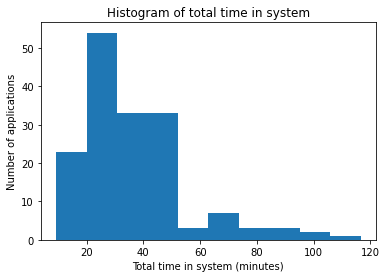

In [71]:
plt.hist(pr_application_log_df['time_in_system'])
plt.title('Histogram of total time in system')
plt.xlabel('Total time in system (minutes)')
plt.ylabel('Number of applications')
plt.show()

In [72]:
pr_application_log_df.loc[:,['wait_for_coordinator', 'wait_for_approver',
                             'wait_for_indirectbuyer', 'time_in_system']].describe()

,wait_for_coordinator,wait_for_approver,wait_for_indirectbuyer,time_in_system
count,162.000000,162.000000,162.000000,162.000000
mean,2.132104,2.832189,4.921994,36.151522
std,3.301396,3.242261,6.681057,19.290109
min,0.000000,0.000000,0.000000,9.251077
25%,0.000000,0.000000,0.000000,23.637969
50%,0.000000,1.723583,2.352542,31.496968
75%,3.512719,4.964716,6.127065,44.911404
max,15.440524,13.585242,29.030701,116.544595


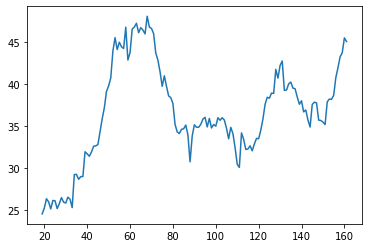

In [73]:
# rolling mean for time in system
y = pr_application_log_df['time_in_system'].rolling(20, 20).mean()
plt.plot(y)

**Resource utilization**


In [74]:
num_coordinators = 7
num_approvers = 2
num_indirectbuyers = 2

In [76]:
available_capacity_coordinator = pr_end_time * num_coordinators
available_capacity_approvers = pr_end_time * num_approvers
available_capacity_indirectbuyers = pr_end_time * num_indirectbuyers

used_capacity_coordinators = pr_application_log_df['time_to_create_PR'].sum()
used_capacity_approvers = pr_application_log_df['time_to_approve'].sum()
used_capacity_indirectbuyers = pr_application_log_df['time_to_issue_po'].sum()

coordinators_utilization = used_capacity_coordinators / available_capacity_coordinator
approvers_utilization = used_capacity_approvers / available_capacity_approvers
indirectbuyers_utilization = used_capacity_indirectbuyers / available_capacity_indirectbuyers

print(f'The utilisation rate of project coordinators is {coordinators_utilization}')
print(f'The utilisation rate of assigned approvers is {approvers_utilization}')
print(f'The utilisation rate of indirect buyers is {indirectbuyers_utilization}')



The utilisation rate of project coordinators is 0.6968301869983082
The utilisation rate of assigned approvers is 0.7940464019971132
The utilisation rate of indirect buyers is 0.7783428558012089
